In [93]:
import os
import openai
import pandas as pd
import numpy as np
import h5py
import requests
import json
import re
import openpyxl
import matplotlib.pyplot as plt
import concurrent.futures
from multiprocessing import Pool

In [122]:
from transformers import pipeline
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import torch

In [2]:
## Get Key
def read_first_cell(file_path):
    workbook = openpyxl.load_workbook(file_path)
    sheet = workbook.active
    first_cell = sheet.cell(row=1, column=1)
    return first_cell.value

file_path = '../openaikey.xlsx'  
first_cell_value = read_first_cell(file_path)

openai.api_key=first_cell_value
API_ENDPOINT = "https://api.openai.com/v1/chat/completions"

### Using a dataframe to generate fake value

In [119]:
# Load and preprocess data
dir = '~/DataAnalysis/data/Sprints/HighRes/'
df = pd.read_hdf(dir+'Windy/WindyMASigned.h5')

In [120]:
df1=df[0:150000]
df1=df1.round(3)

In [123]:
# Load the BERT model
generator = pipeline('text-generation', model='bert-base-cased', device=0)

# Set the chunk size
chunk_size = 60

# Divide the DataFrame into smaller chunks
num_chunks = (len(df1) - 1) // chunk_size + 1

for chunk_index in range(num_chunks):
    start_index = chunk_index * chunk_size
    end_index = min((chunk_index + 1) * chunk_size, len(df1))
    chunk_df = df1.iloc[start_index:end_index]

    # Convert the chunk DataFrame to textual format
    text_data = ""
    for idx, row in chunk_df.iterrows():
        text_data += f"Odor encounter: {row['odor']}, Location: ({row['xsrc']}, {row['ysrc']}), U velocity: {row['U']}, V velocity: {row['V']}.\n"


If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [127]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-125M")

# Define the generation function
def generate_text(input_row):
    # Prepare the prompt
    prompt = f"Odor encounter: {input_row['odor']}, Location: ({input_row['xsrc']}, {input_row['ysrc']}), U velocity: {input_row['U']}, V velocity: {input_row['V']}. Generate a new odor encounter with its location and wind velocity. Please use the format: Odor encounter: X, Location: (X, Y)"
    
    # Generate new data using BERT
    encoded_prompt = tokenizer.encode(prompt, add_special_tokens=False, return_tensors='pt')
    max_length = 50
    temperature = 0.7
    
    output_sequences = model.generate(
        input_ids=encoded_prompt,
        max_length=max_length + len(encoded_prompt[0]),
        temperature=temperature,
        top_k=0,
        top_p=0.9,
        repetition_penalty=1.2,
        do_sample=True,
        num_return_sequences=1,
    )
    generated_texts = tokenizer.decode(output_sequences[0], skip_special_tokens=True)

    # Parse the generated text
#pattern = r"Odor encounter: (.*), Location: \((.*), (.*)\),"
    pattern = r"Odor encounter: ([+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?), Location: \(([+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?), ([+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)\)"

    match = re.search(pattern, generated_texts)
    
    if match:
        new_entry = {
            "odor": float(match.group(1).strip()),
            "xsrc": float(match.group(2).strip()),
            "ysrc": float(match.group(3).strip()),
        }
        return new_entry
    else:
        print("Failed to parse generated text")


# Generate new data
generated_df = pd.DataFrame(columns=['odor', 'xsrc', 'ysrc'])    
for index, row in df1.iterrows():
    new_entry = generate_text(row)
    if new_entry is not None:
        generated_df = pd.concat([generated_df, pd.DataFrame([result])], ignore_index=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable resul

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable resul

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable resul

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable resul

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable resul

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable resul

KeyboardInterrupt: 

### Train Data Open AI API


In [104]:
# Set the chunk size
chunk_size = 60

# Divide the DataFrame into smaller chunks
num_chunks = (len(df1) - 1) // chunk_size + 1

for chunk_index in range(num_chunks):
    start_index = chunk_index * chunk_size
    end_index = min((chunk_index + 1) * chunk_size, len(df1))
    chunk_df = df1.iloc[start_index:end_index]

    # Convert the chunk DataFrame to textual format
    text_data = ""
    for idx, row in chunk_df.iterrows():
        text_data += f"Odor encounter: {row['odor']}, Location: ({row['xsrc']}, {row['ysrc']}), U velocity: {row['U']}, V velocity: {row['V']}.\n"


In [105]:
test=df[15000:25000]
test=test.round(3)

### Faster Generation using Threads

In [108]:


def generate_odor(input_row):
    prompt = f"{text_data}\nGenerate a new odor encounter with the following location: ({input_row['xsrc']}, {input_row['ysrc']}) and U velocity: {input_row['U']}, V velocity: {input_row['V']}.Please use the format: Odor encounter: X, Location: (X, Y)"
    
    pattern = r"Odor encounter: (.*), Location: \((.*), (.*)\)"
    match = None

    while not match:
        response = openai.Completion.create(
            engine="text-davinci-002",
            prompt=prompt,
            temperature=0.7,
            max_tokens=50,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
        )

        generated_texts = response.choices[0].text.strip()
        match = re.search(pattern, generated_texts)
        if not match:
            print("Failed to parse generated text")
            print("Generated text:", generated_texts)

    new_entry = {
        "odor": float(match.group(1).strip()),
        "xsrc": float(match.group(2).strip()),
        "ysrc": float(match.group(3).strip()),
    }
    return new_entry

# Create a new DataFrame to store generated data
generated_df = pd.DataFrame(columns=['odor', 'xsrc', 'ysrc'])    
num_threads = 8 

with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    results = list(executor.map(generate_odor, test.to_dict('records')))

for result in results:
    if result is not None:
        generated_df = pd.concat([generated_df, pd.DataFrame([result])], ignore_index=True)


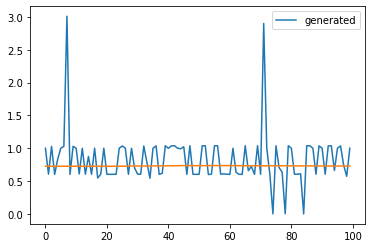

In [100]:
plt.plot(np.arange(0,len(generated_df),1),generated_df.odor,label='generated')
plt.plot(np.arange(0,len(generated_df),1),test.odor)
plt.legend()

# plt.xlim(500,1000)

In [24]:
# Prepare the prompt
prompt = f"{text_data}\nGenerate a new odor encounter with its location and wind velocity"

# Generate new data using GPT-3
response = openai.Completion.create(
    engine="text-davinci-002", 
    prompt=prompt,
    temperature=0.7,
    max_tokens=50,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
)


generated_texts = response.choices[0].text.strip()

pattern = r"Odor encounter: (.*), Location: \((.*), (.*)\), U velocity: (.*), V velocity: (.*)."
match = re.search(pattern, generated_texts)
if match:
    new_entry = {
        "odor": float(match.group(1)),
        "xsrc": float(match.group(2)),
        "ysrc": float(match.group(3)),
        "U": float(match.group(4)),
        "V": float(match.group(5)),
    }
    print(new_entry)
    generated_df = generated_df.append(new_entry, ignore_index=True)
else:
    print("Failed to parse generated text")

,odor,xsrc,ysrc,U,V
0,10.289,1.44,-0.707,1.633,2.008
